# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
  1.0
  ⋮
 -1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
  1.0
 -1.0

### We create a function to visualize the data

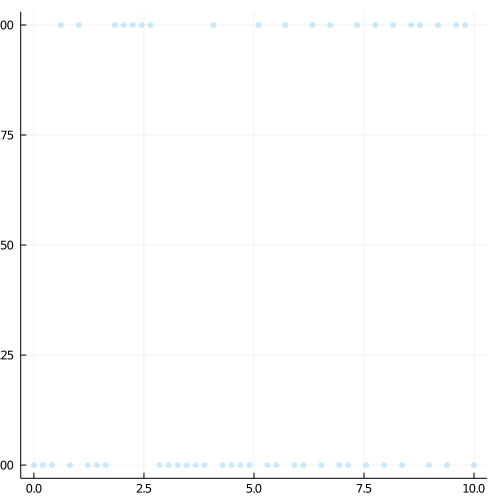

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.593863 seconds (1.14 M allocations: 66.639 MiB, 99.22% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:53
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:29
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:39
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:14
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:59
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.5393281262507346, -0.5096171352731325, -0.4516187104239711, -0.43245670549009235, -0.3560991449384199, -0.22632068272570321, -0.0028172591618365883, 0.2292442808259103, 0.4723778518705932, 0.6146972897555417  …  0.06844396658733393, 0.3396054338791465, 0.5940015877431439, 0.7898134458706335, 0.8943053676052248, 0.9339805668846966, 0.9332426245926817, 0.9055493118091933, 0.9195336255310921, 0.9182763232650434]]
 [[-1.1762800848110206, -1.2533579605513674, -1.2327098945708448, -1.1272223591344646, -1.0034384041954434, -0.9102845915207546, -0.7884714845323875, -0.738703516581991, -0.6864184514495595, -0.5643978794395825  …  -0.35989798447787025, -0.3408361233529813, -0.289617288330631, -0.24348744138743283, -0.21081149305902835, -0.2167186287764301, -0.2531978852366231, -0.3057011811935272, -0.37489566567961774, -0.41449631965357686]]
 [[-1.4766118799833754, -1.383870805381947, -1.15841409020087, -0.9280109446067671, -0.6940183434447976,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

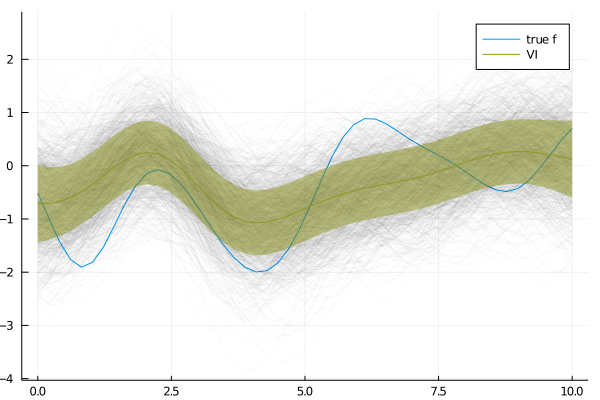

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

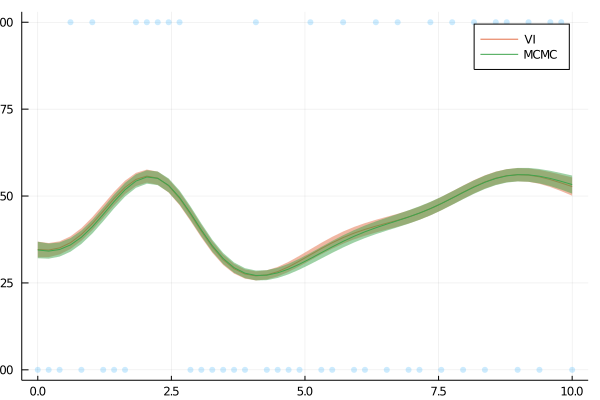

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*